[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shhommychon/neural-style/blob/master/nst.ipynb)

* original author's tutorial available at: [Aladdin Persson YouTube](https://youtu.be/imX4kSKDY7s?t=322)
* author's code is available at: [github repo](https://github.com/shhommychon/neural-style/blob/main/neuralstyle/nst.py)

In [1]:
!git clone https://github.com/shhommychon/neural-style.git

Cloning into 'neural-style'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 26 (delta 0), reused 26 (delta 0), pack-reused 0
Unpacking objects: 100% (26/26), done.


---

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

In [3]:
model = models.vgg19(pretrained=True).features
print(model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        # The first number x in convx_y gets added by 1 after it has gone
        # through a maxpool, and the second y if we have several conv layers
        # in between a max pool. These strings (0, 5, 10, ..) then correspond
        # to conv1_1, conv2_1, conv3_1, conv4_1, conv5_1 mentioned in NST paper
        self.chosen_features = ['0', '5', '10', '19', '28']

        # We don't need to run anything further than conv5_1 (the 28th module in vgg)
        # Since remember, we dont actually care about the output of VGG: the only thing
        # that is modified is the generated image (i.e, the input).
        self.model = models.vgg19(pretrained=True).features[:29]

    def forward(self, x):
        # Store relevant features
        features = []

        # Go through each layer in model, if the layer is in the chosen_features,
        # store it in features. At the end we'll just return all the activations
        # for the specific layers we have in chosen_features
        for layer_num, layer in enumerate(self.model):
            x = layer(x)

            if str(layer_num) in self.chosen_features:
                features.append(x)

        return features

In [5]:
def load_image(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)

    b, c, h, w = image.shape
    # RGBA
    if c == 4:
        image = image[:, :3, :, :]
    # gray
    elif c == 1:
        image = image.expand(b, 3, h, w)

    return image.to(device)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 356

In [7]:
loader = transforms.Compose(
    [
        # 1. Resize
        # Here we need to have all of the images as the same size,
        # otherwise we won't be able to subtract them when we compute
        # the loss.
        transforms.Resize((imsize, imsize)),
     
        # 2. ToTensor
        transforms.ToTensor(),
     
        # 3. Normalize
        # Here we may want to use the Normalization constants used in the original
        # VGG network (to get similar values net was originally trained on), but
        # I found it didn't matter too much so I didn't end of using it. If you
        # use it make sure to normalize back so the images don't look weird.
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [8]:
original_img = load_image("neural-style/neuralstyle/choa.png")
style_img = load_image("neural-style/neuralstyle/style.jpg")

In [9]:
# initialized generated as white noise or clone of original image.

# 1. white noise
# generated = torch.randn(original_img.data.shape, device=device, requires_grad=True)

# 2. clone
# Clone seemed to work better for me.
generated = original_img.clone().requires_grad_(True)

In [10]:
model = VGG().to(device).eval()

In [11]:
# Hyperparameters
total_steps = 6000
learning_rate = 0.001
alpha = 1
beta = 0.01
optimizer = optim.Adam([generated], lr=learning_rate)

In [12]:
from tqdm.notebook import tqdm

for step in tqdm(range(total_steps), total=total_steps):
    # Obtain the convolution features in specifically chosen layers
    generated_features = model(generated)
    original_img_features = model(original_img)
    style_features = model(style_img)

    # Loss is 0 initially
    style_loss = original_loss = 0

    # iterate through all the features for the chosen layers
    for gen_feature, orig_feature, style_feature in zip(
        generated_features, original_img_features, style_features
    ):

        # batch_size will just be 1
        batch_size, channel, height, width = gen_feature.shape
        original_loss += torch.mean((gen_feature - orig_feature) ** 2)
        # Compute Gram Matrix of generated
        G = gen_feature.view(channel, height * width).mm(
            gen_feature.view(channel, height * width).t()
        )
        # Compute Gram Matrix of Style
        A = style_feature.view(channel, height * width).mm(
            style_feature.view(channel, height * width).t()
        )
        style_loss += torch.mean((G - A) ** 2)

    total_loss = alpha * original_loss + beta * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 200 == 0:
        print(f"step #{step:0>4}: " + str(total_loss.cpu().detach().numpy()))
        save_image(generated, "generated.png")

  0%|          | 0/6000 [00:00<?, ?it/s]

step #0000: 1541939.8
step #0200: 71058.75
step #0400: 30226.633
step #0600: 20684.557
step #0800: 16555.928
step #1000: 14056.435
step #1200: 12273.132
step #1400: 10890.133
step #1600: 9751.792
step #1800: 8783.646
step #2000: 7950.39
step #2200: 7219.4385
step #2400: 6582.4297
step #2600: 6031.6255
step #2800: 5556.534
step #3000: 5150.7812
step #3200: 4799.3354
step #3400: 4491.2026
step #3600: 4218.1904
step #3800: 3973.028
step #4000: 3751.9202
step #4200: 3551.6904
step #4400: 3373.2988
step #4600: 3214.5044
step #4800: 3073.0906
step #5000: 2944.6086
step #5200: 2833.5579
step #5400: 2733.6917
step #5600: 2645.023
step #5800: 2562.634


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


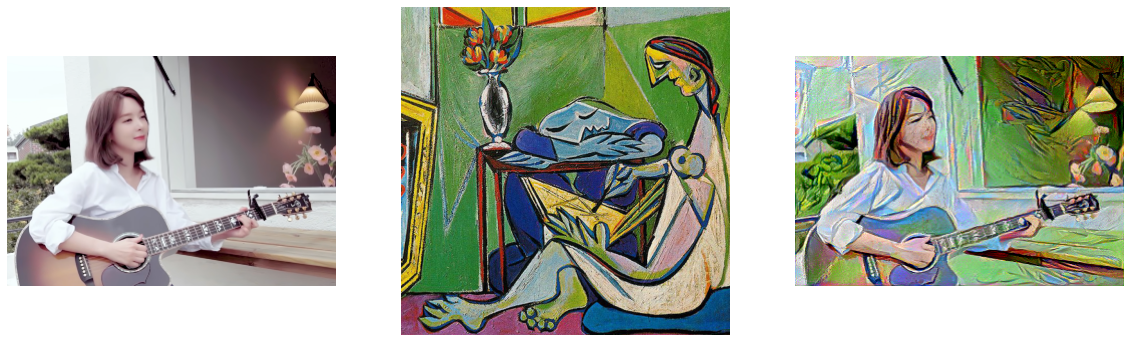

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
axes = axes.flatten()

original_img_plt = mpimg.imread("neural-style/neuralstyle/choa.png")
axes[0].imshow(original_img_plt)
axes[0].axis("off")

style_img_plt = mpimg.imread("neural-style/neuralstyle/style.jpg")
axes[1].imshow(style_img_plt)
axes[1].axis("off")

generated_img_plt = mpimg.imread("generated.png")
h, w, c = original_img_plt.shape
generated_img_cv2 = cv2.resize(generated_img_plt, dsize=(w, h), interpolation=cv2.INTER_CUBIC)
axes[2].imshow(generated_img_cv2)
axes[2].axis("off")

plt.show()

In [14]:
generated_img_cv2 = cv2.cvtColor(generated_img_cv2, cv2.COLOR_BGR2RGB)
generated_img_cv2 = generated_img_cv2 * 255
cv2.imwrite("generated_resized.png", generated_img_cv2)

True